### practice linear regression using Boston House Prices Dataset

structure:

1. get the analytic solution first
2. then use tensorflow to implement the linear regression

In [9]:
%matplotlib inline
import numpy as np

# A new one for this lab!
import tensorflow.compat.v1 as tf

from sklearn import datasets as ds

import matplotlib.pyplot as plt

In [2]:
boston = ds.load_boston()

x_raw = boston.data[:,np.argwhere(boston.feature_names == 'RM')[0,0]]
#'RM': average number of rooms per dwelling
y_raw = boston.target

In [3]:
#prepare data
total_count = x_raw.shape[0]

split = int(total_count * 0.6)

# Shuffle the data to avoid any ordering bias..
np.random.seed(0)
shuffle = np.random.permutation(total_count)

x = x_raw[shuffle]
y = y_raw[shuffle]

x_train_unnormalised = x[:split]
y_train_unnormalised = y[:split]

x_test_unnormalised = x[split:]
y_test_unnormalised = y[split:]

print('Training set size:', x_train_unnormalised.shape[0])
print('Test set size:', x_test_unnormalised.shape[0])

Training set size: 303
Test set size: 203


Text(0.5, 1.0, 'Plot of the Training Data')

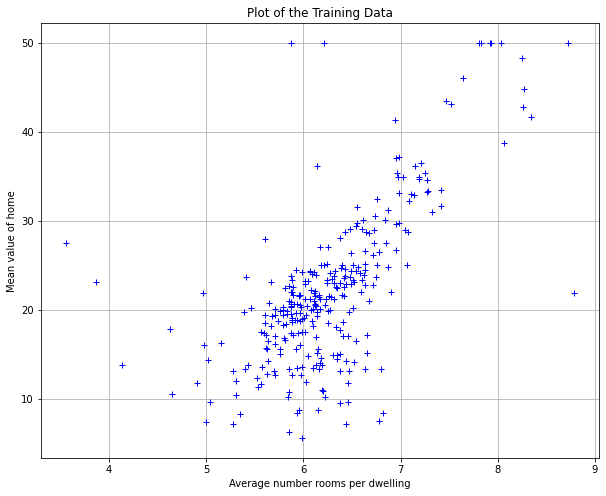

In [4]:
#data visulization

def plot_data(x, y):
    plt.figure(figsize=[10,8])
    plt.plot(x, y, 'b+')
    plt.grid(True)
    plt.xlabel('Average number rooms per dwelling')
    plt.ylabel('Mean value of home')

plot_data(x_train_unnormalised, y_train_unnormalised)
plt.title('Plot of the Training Data')

Passes checking function :)


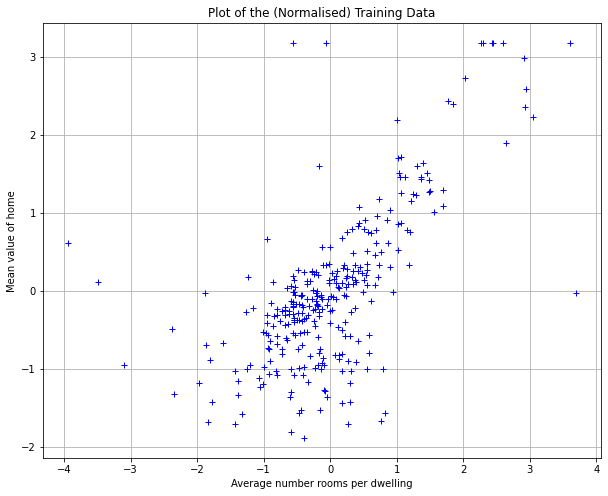

In [5]:
def normalise_data(x_unnormalised):
    # Add your code here..
    m = np.mean(x_unnormalised)
    s = np.std(x_unnormalised)
    x_normalised = (x_unnormalised-m)/s
    b = m
    a = s
    # ************************************************************    
    return x_normalised, a, b


def unnormalise_data(x_normalised, a, b):
    # Add your code here..
    x_unnormalised = a * x_normalised + b
    # ************************************************************
    return x_unnormalised

try:
    x_train, x_norm_a, x_norm_b = normalise_data(x_train_unnormalised)
    y_train, y_norm_a, y_norm_b = normalise_data(y_train_unnormalised)

    x_test, _, _ = normalise_data(x_test_unnormalised)
    y_test, _, _ = normalise_data(y_test_unnormalised)
except Exception as err:
    print('Error during normalisation functions:', err)

def checking_function(normalise_data, unnormalise_data, data_to_check):
    passes_check = False
    
    est_normalised_data, est_a, est_b = normalise_data(data_to_check)
    est_unnormalised_data = unnormalise_data(est_normalised_data, est_a, est_b)
    
    # Add your code here to check that the unnormaliseding the 
    # training data returns to their original values and update 
    # the passes_check boolean..
    passes_check = np.all(np.isclose(est_unnormalised_data, data_to_check))
    # ************************************************************

    
    return passes_check

try:
    if (checking_function(normalise_data, unnormalise_data, x_train_unnormalised) == True) and \
       (checking_function(normalise_data, unnormalise_data, y_train_unnormalised) == True):
        print('Passes checking function :)')
    else:
        print('Failed to pass the checking function :(')
except Exception as err:
    print('Error during checking function:', err)

# Plot the data to make sure they are normalised..
try:
    plot_data(x_train, y_train)
    plt.title('Plot of the (Normalised) Training Data')
except Exception as err:
    print('Error during ploting functions:', err)

In [6]:
def least_squares_error(x, y, w, c):
    # calcuate the squared_error = E(w,c)..
    squared_error=0
    for i in range(len(x)):
        s = (y[i]- w*x[i]-c)**2
        squared_error=squared_error+s
    # ************************************************************
    
    return squared_error

try:
    print('Squared error for w = 1.5, c = 0.5 is ', 
          least_squares_error(x_train, y_train, w=1.5, c=0.5))
except Exception as err:
    print('Error during least squares calculation:', err)

Squared error for w = 1.5, c = 0.5 is  450.52041703162615


Analytic solution:
Analytic w =  0.6710446457297835
Analytic c =  1.2195548195136355e-15


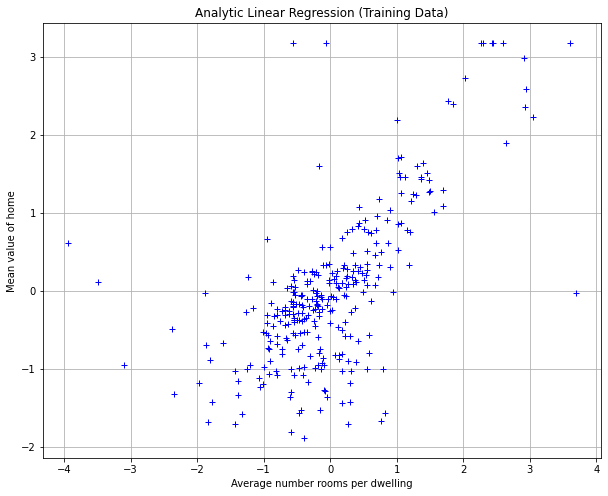

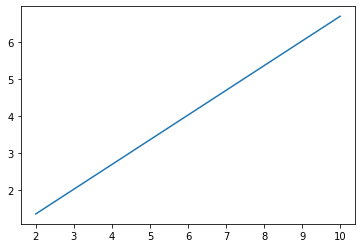

Mean least squares error on TRAINING data =  0.5496990834373898


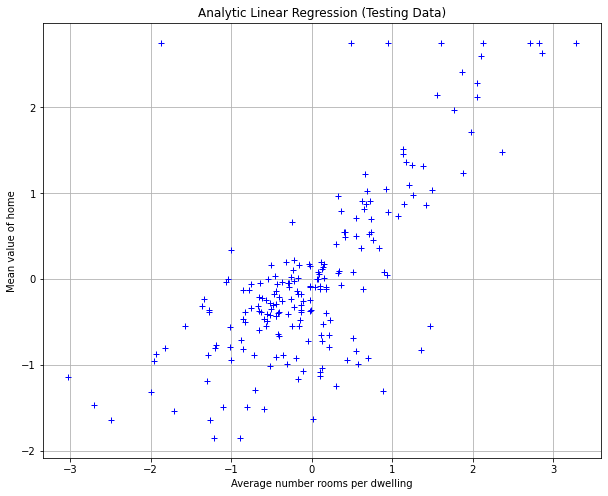

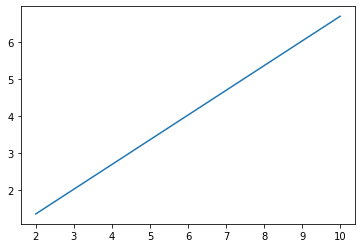

Mean least squares error on TEST data =  0.47744611553743393


In [7]:
def least_squares_analytic_solution(x, y):
    # calcuate the optimal w and c using the 
    # ************************************************************
    A = np.sum(x**2)
    B = np.sum(x)
    C = np.sum(x*y)
    D = np.sum(y)
    N = len(x)
    c = (B*C-A*D)/(B**2-A*N)
    w = (D-N*c)/B
    
    return w, c


try:
    w_opt, c_opt = least_squares_analytic_solution(x_train, y_train)
    
    print('Analytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error during least squares analytic solution:', err)

    
def plot_estimated_y_for_input_x(w, c):
    x = np.linspace(2, 10, num=100)
    y= w*x+c
    plt.figure()
    plt.plot(x,y)
    plt.show()
    pass
    
    

try:
    plot_data(x_train, y_train)
    plt.title('Analytic Linear Regression (Training Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt)
    
    print('Mean least squares error on TRAINING data = ',
          least_squares_error(x_train, y_train, w_opt, c_opt) / x_train.shape[0])

    plot_data(x_test, y_test)
    plt.title('Analytic Linear Regression (Testing Data)')
    plot_estimated_y_for_input_x(w_opt, c_opt)
    
    print('Mean least squares error on TEST data = ',
          least_squares_error(x_test, y_test, w_opt, c_opt) / x_test.shape[0])
    
except Exception as err:
    print('Error during plotting:', err)

## Tensorflow Optimisation

In [10]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')


def calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c):
    
    # Add your code here to calculate t_least_squares_error..
    y_est = t_w * t_x_train+t_c
    t_se_term = (y_est-t_y_train)**2
    t_least_squares_error = tf.reduce_sum(t_se_term)
    # ************************************************************

    
    return t_least_squares_error


try:
    tensorflow_result = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)
except Exception as err:
    print('Error declaration of calculate_tf_least_squares_error():', err)
    
try:
    # Check with the result from your previous function..
    numpy_result = least_squares_error(x_train, y_train, 
                                       w=w_initial_guess, 
                                       c=c_initial_guess)
    print('Tensorflow least squares error = ', tensorflow_result.numpy())
    print('numpy least squares error = ', numpy_result)    
    
    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tensorflow_result, numpy_result))
except Exception as err:
    print('Error during optimisation with calculate_tf_least_squares_error():', err)

Tensorflow least squares error =  450.52041703162615
numpy least squares error =  450.52041703162615


In [11]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    with tf.GradientTape() as tape:
        loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

    tf_grad_w,tf_grad_c = tape.gradient(loss, (t_w,t_c))

    print('Tensorflow gradient wrt w = ', tf_grad_w.numpy())
    print('Tensorflow gradient wrt c = ', tf_grad_c.numpy())
    
except Exception as err:
    print('Error using calculate_tf_least_squares_error() to find gradients:', err)
    

def calc_gradients_for_least_squares(x, y, w, c):
    # Add your code to evalute the partial derivatives here
    A = np.sum(x**2)
    B = np.sum(x)
    C = np.sum(x*y)
    D = np.sum(y)
    N = len(x)
    grad_w = 2* (c*B+w*A-C)
    grad_c = 2* (c*N+w*B-D)
    # ************************************************************
    # ...
    return grad_w, grad_c

try:
    numpy_grad_w, numpy_grad_c = calc_gradients_for_least_squares(x_train, 
                                                                  y_train, 
                                                                  w_initial_guess, 
                                                                  c_initial_guess)

    print('Analytic gradient wrt w = ', numpy_grad_w)
    print('Analytic gradient wrt c = ', numpy_grad_c)

    # This should pass if they are the same to nummerical precision!
    assert(np.isclose(tf_grad_w, numpy_grad_w))
    assert(np.isclose(tf_grad_c, numpy_grad_c))
except Exception as err:
    print('Error during calculation with calc_gradients_for_least_squares():', err)

Tensorflow gradient wrt w =  502.34694468775075
Tensorflow gradient wrt c =  302.9999999999985
Analytic gradient wrt w =  502.3469446877507
Analytic gradient wrt c =  302.9999999999984


## Gradient Descent in Tensorflow

In [12]:
tf.reset_default_graph()

try:
    # Constants to hold the training data..
    t_x_train = tf.constant(x_train, name='x_train')
    t_y_train = tf.constant(y_train, name='y_train')
except Exception as err:
    print('Error defining training data:', err)
    
# Initial values for optimisation..
w_initial_guess = 1.5
c_initial_guess = 0.5

# Variables to hold w and c
t_w = tf.Variable(w_initial_guess, 
                  dtype=tf.float64, 
                  name='w')
t_c = tf.Variable(c_initial_guess, 
                  dtype=tf.float64, 
                  name='c')

try:
    optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.001) #0.001
    
    # Number of iterations to perform
    num_iterations = 40
   
    # Run a number of iterations of gradient descent..
    for iteration in range(num_iterations):
        
        with tf.GradientTape() as tape:
            # We want to minimise the least squares error
            loss = calculate_tf_least_squares_error(t_x_train, t_y_train, t_w, t_c)

        tf_grad_w,tf_grad_c = tape.gradient(loss, (t_w,t_c))
        # Create a gradient descent optimiser that uses a
        # certain step size (learning_rate)..

        optimiser.apply_gradients(zip((tf_grad_w,tf_grad_c),(t_w,t_c)))
    
        print('iter %4d, E(w,c) = %0.3f' % 
                  (iteration + 1, loss))

    # Get the final results of the optimisation..
    w_tf_opt = t_w.numpy()
    c_tf_opt = t_c.numpy()

    print('\nAfter tensorflow optimisation:')
    print('Tensorflow w = ', w_tf_opt)
    print('Tensorflow c = ', c_tf_opt)
    
    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
    print('Error using calculate_tf_least_squares_error():', err)

iter    1, E(w,c) = 450.520
iter    2, E(w,c) = 210.640
iter    3, E(w,c) = 173.402
iter    4, E(w,c) = 167.621
iter    5, E(w,c) = 166.724
iter    6, E(w,c) = 166.584
iter    7, E(w,c) = 166.563
iter    8, E(w,c) = 166.559
iter    9, E(w,c) = 166.559
iter   10, E(w,c) = 166.559
iter   11, E(w,c) = 166.559
iter   12, E(w,c) = 166.559
iter   13, E(w,c) = 166.559
iter   14, E(w,c) = 166.559
iter   15, E(w,c) = 166.559
iter   16, E(w,c) = 166.559
iter   17, E(w,c) = 166.559
iter   18, E(w,c) = 166.559
iter   19, E(w,c) = 166.559
iter   20, E(w,c) = 166.559
iter   21, E(w,c) = 166.559
iter   22, E(w,c) = 166.559
iter   23, E(w,c) = 166.559
iter   24, E(w,c) = 166.559
iter   25, E(w,c) = 166.559
iter   26, E(w,c) = 166.559
iter   27, E(w,c) = 166.559
iter   28, E(w,c) = 166.559
iter   29, E(w,c) = 166.559
iter   30, E(w,c) = 166.559
iter   31, E(w,c) = 166.559
iter   32, E(w,c) = 166.559
iter   33, E(w,c) = 166.559
iter   34, E(w,c) = 166.559
iter   35, E(w,c) = 166.559
iter   36, E(w,c) = 

In [13]:
# Keep track of parameter values over iterations..
w_current = w_initial_guess
c_current = c_initial_guess

try:
    # Keep track of the error..
    E_current = least_squares_error(x_train, y_train, w_current, c_current)
except Exception as err:
    print('Error defining training data:', err)

# Keep track of the step size..
current_step_size = 0.1 #0.001

num_iterations = 200 #20

converge_threshold = 1e-8

try:
    for iteration in range(num_iterations):

        def run_iteration(x_train, y_train, w_current, c_current, E_current, 
                          current_step_size, converge_threshold):

            # Set to True when converged..
            converged = False

            # Add code to evaluate the gradients..
            # ************************************************************
            # ...
            grad_w, grad_c = calc_gradients_for_least_squares(x_train, y_train, w_current, c_current)

            # Add code to take a step in the direction of the negative
            # gradient proportional to the step size..
            # ************************************************************
            # ...
            w_new = w_current - grad_w * current_step_size
            c_new = c_current - grad_c * current_step_size


            # Add code to evaluate and remember the squared error..
            # ************************************************************
            # ...
            E_new = least_squares_error(x_train, y_train, w_new, c_new)


            # Add code to check that error is decreasing and reduce step
            # size if not..
            # ************************************************************
            while E_new > E_current:
                current_step_size = current_step_size/10
                w_new = w_current - grad_w * current_step_size
                c_new = c_current - grad_c * current_step_size
                E_new = least_squares_error(x_train, y_train, w_new, c_new)
            # ...


            
            #If the change in the squared error between successive iterations is very small then one of the following is true. 
            #Either the step size is too small (not changing the parameters sufficiently) 
            #or the values have converged to their optimal values. 
            #If you cannot find a step size that creates a deacrease in the squared error 
            #then you have probably converged and can stop performing iterations.
            
            
            # Add code to check for convergence and terminate
            # the loop if converged..
            if (E_current-E_new)<converge_threshold:
                if current_step_size<converge_threshold:
                    converged = False
                else:
                    converged = True
            else:
                pass
                
                
                
            
            # ************************************************************
            # ...
            
            
            # Take the step
            w_current = w_new
            c_current = c_new
            E_current = E_new
            return w_current, c_current, E_current, current_step_size, converged


        w_current, c_current, E_current, current_step_size, converged = \
            run_iteration(x_train, y_train, w_current, c_current, E_current, 
                          current_step_size, converge_threshold)
        
        print('iteration %4d, E = %f, w = %f, c = %f' % 
              (iteration, E_current, w_current, c_current))
        
        if converged:
            # Break out of iteration loop..
            print('Converged!')
            break
        
    print('\nAfter gradient descent optimisation:')
    print('Optimised w = ', w_current)
    print('Optimised c = ', c_current)

    print('\nAnalytic solution:')
    print('Analytic w = ', w_opt)
    print('Analytic c = ', c_opt)
    
except Exception as err:
        print('Error during run_iteration():', err)

iteration    0, E = 210.639884, w = 0.997653, c = 0.197000
iteration    1, E = 173.401790, w = 0.799728, c = 0.077618
iteration    2, E = 167.621097, w = 0.721746, c = 0.030581
iteration    3, E = 166.723726, w = 0.691021, c = 0.012049
iteration    4, E = 166.584421, w = 0.678915, c = 0.004747
iteration    5, E = 166.562796, w = 0.674146, c = 0.001870
iteration    6, E = 166.559439, w = 0.672266, c = 0.000737
iteration    7, E = 166.558918, w = 0.671526, c = 0.000290
iteration    8, E = 166.558837, w = 0.671234, c = 0.000114
iteration    9, E = 166.558825, w = 0.671119, c = 0.000045
iteration   10, E = 166.558823, w = 0.671074, c = 0.000018
iteration   11, E = 166.558822, w = 0.671056, c = 0.000007
iteration   12, E = 166.558822, w = 0.671049, c = 0.000003
iteration   13, E = 166.558822, w = 0.671046, c = 0.000001
Converged!

After gradient descent optimisation:
Optimised w =  0.6710464465827126
Optimised c =  1.086218287775251e-06

Analytic solution:
Analytic w =  0.6710446457297835
A